In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import sys

In [3]:
from tqdm.notebook import tqdm

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [5]:
cov_ds = pd.read_csv('../Covid_19_aggregated.csv').drop(['Unnamed: 0','Unnamed: 0.1'], 1)
print(cov_ds.shape)
cov_ds.head()

(29328, 80)


,Country,Lat,Long,Date,Confirmed,Deaths,Recovered,C1_School closing,C2_Workplace closing,C3_Cancel public events,...,embeddingval11,embeddingval12,embeddingval13,embeddingval14,embeddingval15,embeddingval16,embeddingval17,embeddingval18,embeddingval19,embeddingval20
0,Afghanistan,33.0,65.0,01/22/2020,0,0,0,0.0,0.0,0.0,...,-0.003286,-0.017812,0.023981,-0.001198,-0.007451,0.023493,0.021881,-0.013652,0.019966,0.022902
1,Afghanistan,33.0,65.0,01/23/2020,0,0,0,0.0,0.0,0.0,...,-0.003286,-0.017812,0.023981,-0.001198,-0.007451,0.023493,0.021881,-0.013652,0.019966,0.022902
2,Afghanistan,33.0,65.0,01/24/2020,0,0,0,0.0,0.0,0.0,...,-0.003286,-0.017812,0.023981,-0.001198,-0.007451,0.023493,0.021881,-0.013652,0.019966,0.022902
3,Afghanistan,33.0,65.0,01/25/2020,0,0,0,0.0,0.0,0.0,...,-0.003286,-0.017812,0.023981,-0.001198,-0.007451,0.023493,0.021881,-0.013652,0.019966,0.022902
4,Afghanistan,33.0,65.0,01/26/2020,0,0,0,0.0,0.0,0.0,...,-0.003286,-0.017812,0.023981,-0.001198,-0.007451,0.023493,0.021881,-0.013652,0.019966,0.022902


In [6]:
polc_columns_C = ['C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',
       'C4_Restrictions on gatherings', 'C5_Close public transport',
       'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
       'C8_International travel controls']
polc_columns_E = ['E1_Income support','E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', ]
polc_columns_H = ['H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines']

In [243]:
s = cov_ds[polc_columns_C+polc_columns_E+polc_columns_H].nunique()<5
s = s[s].index
polc_columns_cat = list(s)

In [285]:
cov_ds['Date_dt'] = pd.to_datetime(cov_ds['Date'])

In [293]:
for f in ['Confirmed','Deaths','Recovered']:
    cov_ds[f'{f}_lag1'] = None
    for v in cov_ds['Country'].unique():
        cds = cov_ds[cov_ds['Country']==v].sort_values('Date_dt')
        cov_ds.loc[cds.index, f'{f}_lag1'] = cds[f'{f}'].shift(1)
    #cov_ds['Confirmed_lag1'] = cds['Confirmed'].shift(1)
    cov_ds[f'{f}_diff'] = (cov_ds[f'{f}']-cov_ds[f'{f}_lag1']).fillna(0)
    cov_ds[f'{f}_diff_per_pop'] = cov_ds[f'{f}_diff']/cov_ds['Population']
    

# Analyze Max Policies by Kmeans

In [7]:
pols_ds_C = cov_ds.groupby('Country')[polc_columns_C].max().fillna(-1)

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [9]:
nclusters = list(range(2,15+1))
sils = []
for nclust in tqdm(nclusters):
    for i in range(100):
        km = KMeans(n_clusters=nclust, random_state=i)
        preds = km.fit_predict(pols_ds_C[polc_columns_C])
        sils.append({'n':nclust, 'sil':silhouette_score(pols_ds_C[polc_columns_C], preds)})

In [10]:
sils = pd.DataFrame(sils)

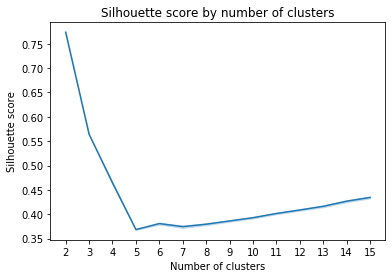

In [11]:
sns.lineplot(x='n', y='sil',data=sils)
#plt.plot(nclusters, sils)
plt.title('Silhouette score by number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.xticks(nclusters, nclusters)
plt.show()

In [12]:
km = KMeans(n_clusters=4)

In [13]:
pols_ds_C['cluster'] = km.fit_predict(pols_ds_C[polc_columns_C])

In [14]:
preds = km.fit_predict(pols_ds_C[polc_columns_C])
silhouette_score(pols_ds_C[polc_columns_C], preds)

0.46275397805248797

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
rf =  DecisionTreeClassifier()# RandomForestClassifier()
rf.fit(pols_ds_C[polc_columns_C], pols_ds_C['cluster'])
fimps = pd.Series(rf.feature_importances_, index=polc_columns_C)

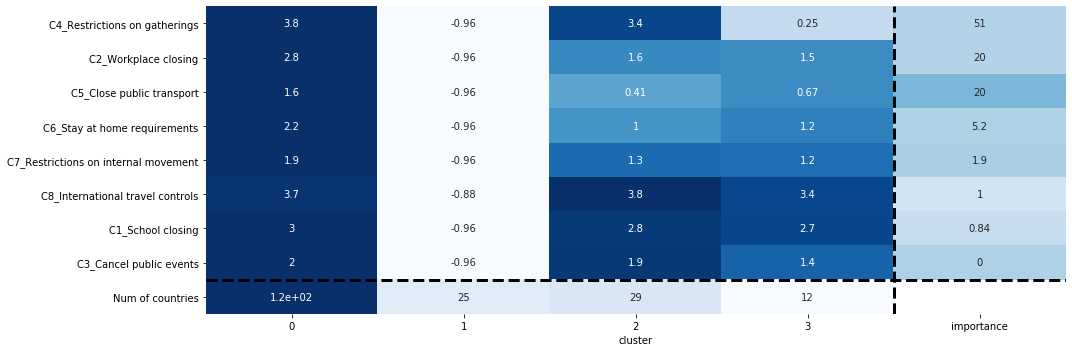

In [16]:
cds = pols_ds_C.groupby('cluster')[polc_columns_C].mean().T
cds['importance'] = fimps
cds = cds.sort_values('importance', ascending=False)


cds.loc['Num of countries'] = pols_ds_C.groupby('cluster')[polc_columns_C[0]].count()
cds_verb = cds.copy()
cds = ((cds.T-cds.T.min())/(cds.T.max()-cds.T.min())).T

cds_verb['importance'] = (cds_verb['importance']*100).round(2)
cds_verb.round(2).astype(str)


plt.figure(figsize=(15,5))
sns.heatmap(cds, cmap='Blues', annot=cds_verb, cbar=False)
plt.axhline(len(polc_columns_C), linestyle='--', linewidth=3, color='black')
plt.axvline(pols_ds_C['cluster'].nunique(), linestyle='--', linewidth=3, color='black')

plt.tight_layout()
plt.show()

In [17]:
import sklearn

In [18]:
sklearn.__version__

'0.22.1'

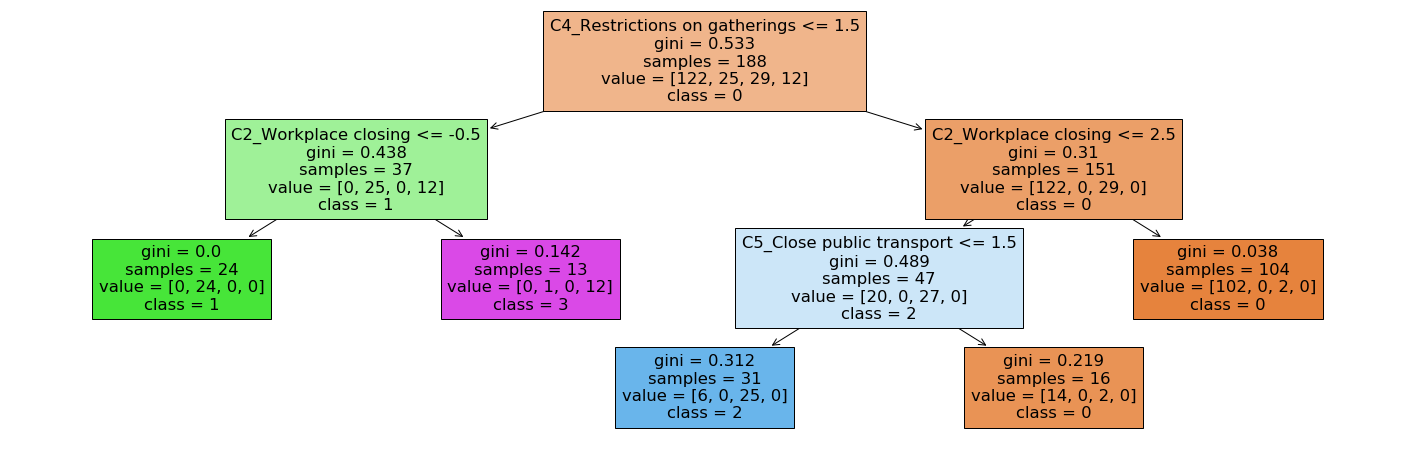

In [168]:
dtree = DecisionTreeClassifier(max_depth=3, min_impurity_decrease=0.05, random_state=42)
dtree.fit(pols_ds_C[polc_columns_C], pols_ds_C['cluster'])#pols_ds_C['cluster'])

plt.figure(figsize=(25,8))
plot_tree(dtree, feature_names=polc_columns_C, filled=True, class_names=[str(x) for x in range(4)]);

In [163]:
pols_ds_C['cluster_dtree'] = dtree.predict(pols_ds_C[polc_columns_C])

In [169]:
cluster_desc = {0:'Stringent policies',
               1:'Unknown policies',
               2:'No gatherings',
               3:'Lenient policies'}

In [46]:
for f in ['Confirmed','Deaths','Recovered']:
    cov_ds[f+'_per_pop'] = cov_ds[f]/cov_ds['Population']

In [172]:
d = pols_ds_C['cluster_dtree'].to_dict()
cov_ds['Cluster_max_policy'] = cov_ds['Country'].apply(lambda x: d[x])
cov_ds['Cluster_max_policy_verb'] = cov_ds['Cluster_max_policy'].apply(lambda x: cluster_desc[x])

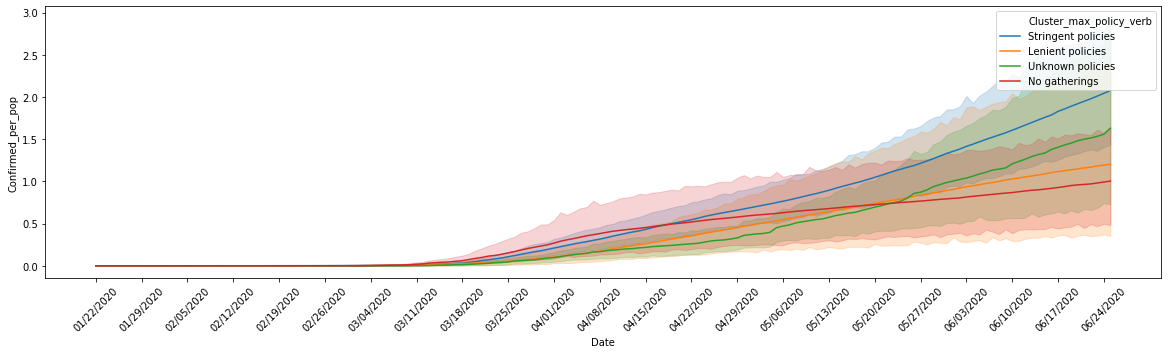

In [174]:
plt.figure(figsize=(20,5))
sns.lineplot(x='Date', y='Confirmed_per_pop', data=cov_ds, hue='Cluster_max_policy_verb')
xticks = cov_ds['Date'].sort_values().drop_duplicates().values
plt.xticks(range(0, len(xticks), 7), xticks[::7], rotation=45)
#plt.xticks(xticks[0][::7], [x.get_text() for x in xticks[1]][::7], rotation=90)
plt.show()

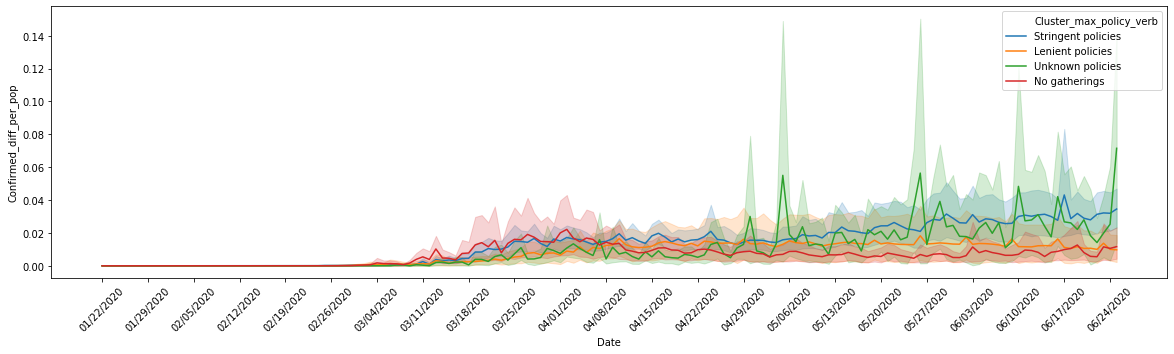

In [294]:
plt.figure(figsize=(20,5))
sns.lineplot(x='Date', y='Confirmed_diff_per_pop', data=cov_ds, hue='Cluster_max_policy_verb')
xticks = cov_ds['Date'].sort_values().drop_duplicates().values
plt.xticks(range(0, len(xticks), 7), xticks[::7], rotation=45)
#plt.xticks(xticks[0][::7], [x.get_text() for x in xticks[1]][::7], rotation=90)
plt.show()

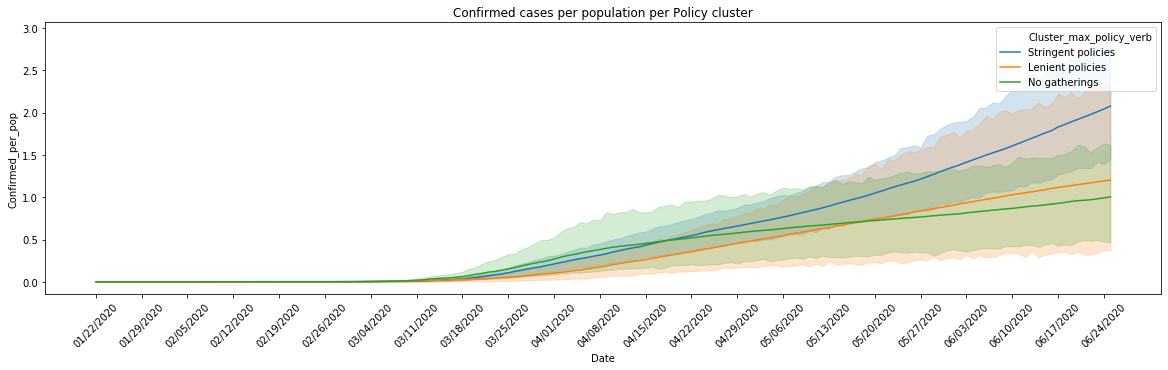

In [177]:
plt.figure(figsize=(20,5))
sns.lineplot(x='Date', y='Confirmed_per_pop', hue='Cluster_max_policy_verb',
            data=cov_ds[~cov_ds['Cluster_max_policy_verb'].isin(['Unknown policies'])])
xticks = cov_ds['Date'].sort_values().drop_duplicates().values
plt.xticks(range(0, len(xticks), 7), xticks[::7], rotation=45)
#plt.xticks(xticks[0][::7], [x.get_text() for x in xticks[1]][::7], rotation=90)
plt.title('Confirmed cases per population per Policy cluster')
plt.show()

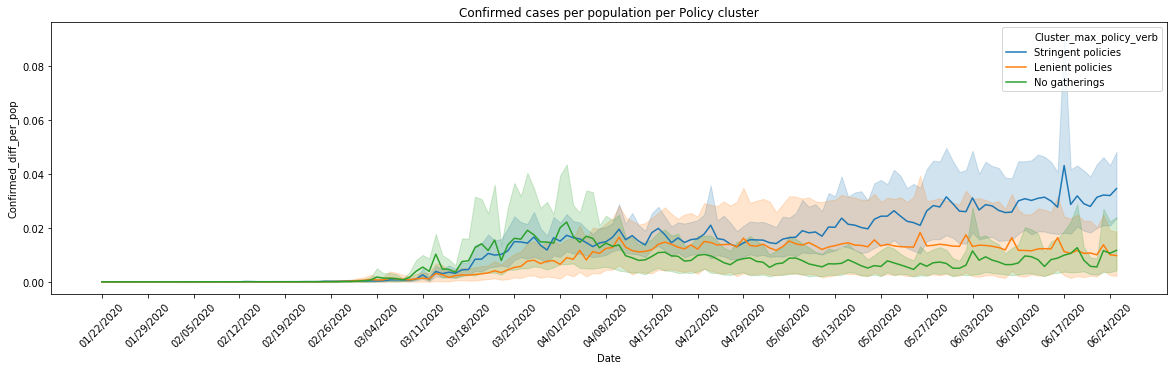

In [295]:
plt.figure(figsize=(20,5))
sns.lineplot(x='Date', y='Confirmed_diff_per_pop', hue='Cluster_max_policy_verb',
            data=cov_ds[~cov_ds['Cluster_max_policy_verb'].isin(['Unknown policies'])])
xticks = cov_ds['Date'].sort_values().drop_duplicates().values
plt.xticks(range(0, len(xticks), 7), xticks[::7], rotation=45)
#plt.xticks(xticks[0][::7], [x.get_text() for x in xticks[1]][::7], rotation=90)
plt.title('Confirmed cases per population per Policy cluster')
plt.show()

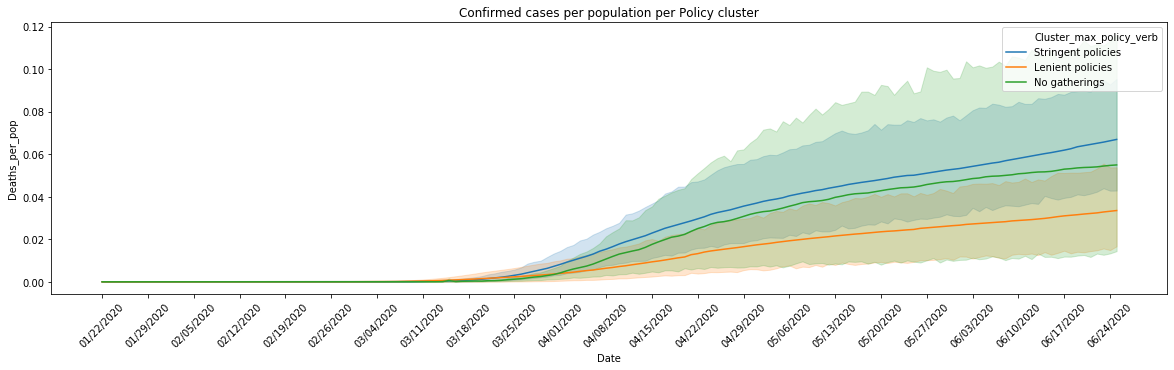

In [178]:
plt.figure(figsize=(20,5))
sns.lineplot(x='Date', y='Deaths_per_pop', hue='Cluster_max_policy_verb',
            data=cov_ds[~cov_ds['Cluster_max_policy_verb'].isin(['Unknown policies'])])
xticks = cov_ds['Date'].sort_values().drop_duplicates().values
plt.xticks(range(0, len(xticks), 7), xticks[::7], rotation=45)
#plt.xticks(xticks[0][::7], [x.get_text() for x in xticks[1]][::7], rotation=90)
plt.title('Death cases per population per Policy cluster')
plt.show()

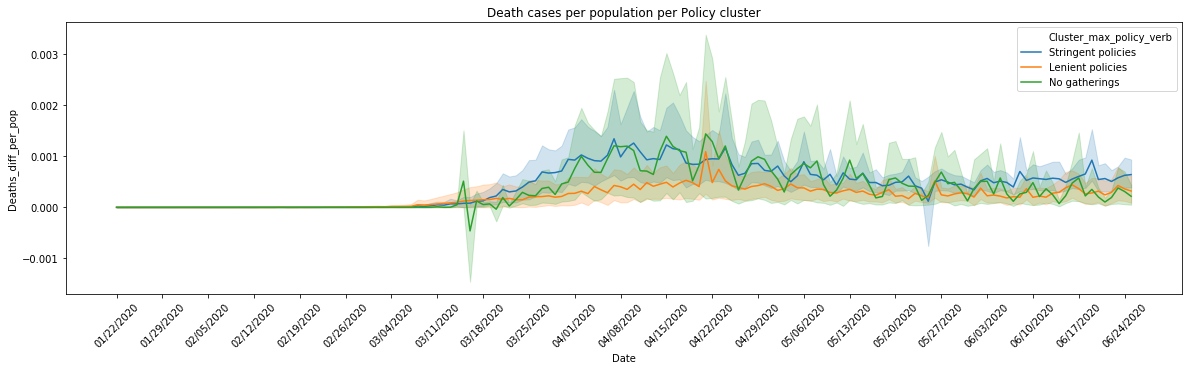

In [296]:
plt.figure(figsize=(20,5))
sns.lineplot(x='Date', y='Deaths_diff_per_pop', hue='Cluster_max_policy_verb',
            data=cov_ds[~cov_ds['Cluster_max_policy_verb'].isin(['Unknown policies'])])
xticks = cov_ds['Date'].sort_values().drop_duplicates().values
plt.xticks(range(0, len(xticks), 7), xticks[::7], rotation=45)
#plt.xticks(xticks[0][::7], [x.get_text() for x in xticks[1]][::7], rotation=90)
plt.title('Death cases per population per Policy cluster')
plt.show()

# Analyze All Max Policies by Kmeans

In [248]:
pols_ds_cat = cov_ds.groupby('Country')[polc_columns_cat].max().fillna(-1)

In [249]:
nclusters = list(range(2,15+1))
sils = []
for nclust in tqdm(nclusters):
    for i in range(100):
        km = KMeans(n_clusters=nclust, random_state=i)
        preds = km.fit_predict(pols_ds_cat[polc_columns_cat])
        sils.append({'n':nclust, 'sil':silhouette_score(pols_ds_cat[polc_columns_cat], preds)})

In [250]:
sils = pd.DataFrame(sils)

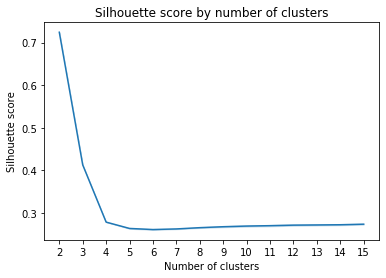

In [251]:
sns.lineplot(x='n', y='sil',data=sils)
#plt.plot(nclusters, sils)
plt.title('Silhouette score by number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.xticks(nclusters, nclusters)
plt.show()

In [252]:
km = KMeans(n_clusters=4)

In [263]:
pols_ds_cat['cluster_catpols'] = km.fit_predict(pols_ds_cat[polc_columns_cat])

In [264]:
preds = km.fit_predict(pols_ds_cat[polc_columns_cat])
silhouette_score(pols_ds_cat[polc_columns_cat], preds)

0.27834384618730146

In [266]:
rf =  DecisionTreeClassifier()# RandomForestClassifier()
rf.fit(pols_ds_cat[polc_columns_cat], pols_ds_cat['cluster_catpols'])
fimps = pd.Series(rf.feature_importances_, index=polc_columns_cat)

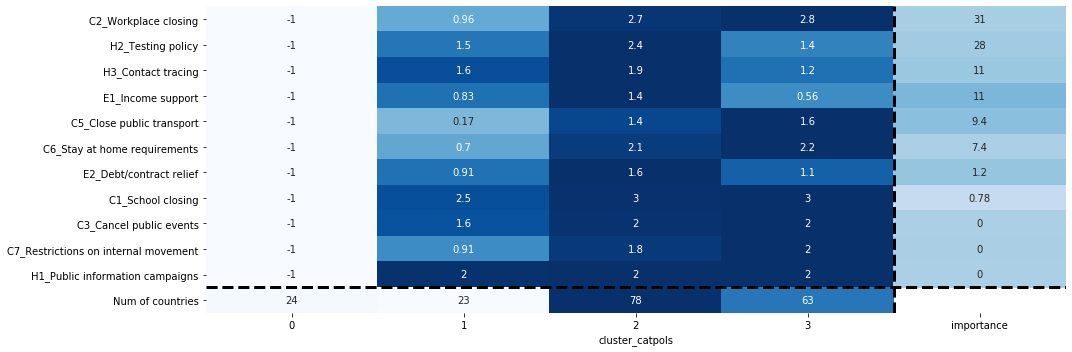

In [269]:
cds = pols_ds_cat.groupby('cluster_catpols')[polc_columns_cat].mean().T
cds['importance'] = fimps
cds = cds.sort_values('importance', ascending=False)


cds.loc['Num of countries'] = pols_ds_cat.groupby('cluster_catpols')[polc_columns_cat[0]].count()
cds_verb = cds.copy()
cds = ((cds.T-cds.T.min())/(cds.T.max()-cds.T.min())).T

cds_verb['importance'] = (cds_verb['importance']*100).round(2)
cds_verb.round(2).astype(str)


plt.figure(figsize=(15,5))
sns.heatmap(cds, cmap='Blues', annot=cds_verb, cbar=False)
plt.axhline(len(polc_columns_cat), linestyle='--', linewidth=3, color='black')
plt.axvline(pols_ds_cat['cluster_catpols'].nunique(), linestyle='--', linewidth=3, color='black')

plt.tight_layout()
plt.show()

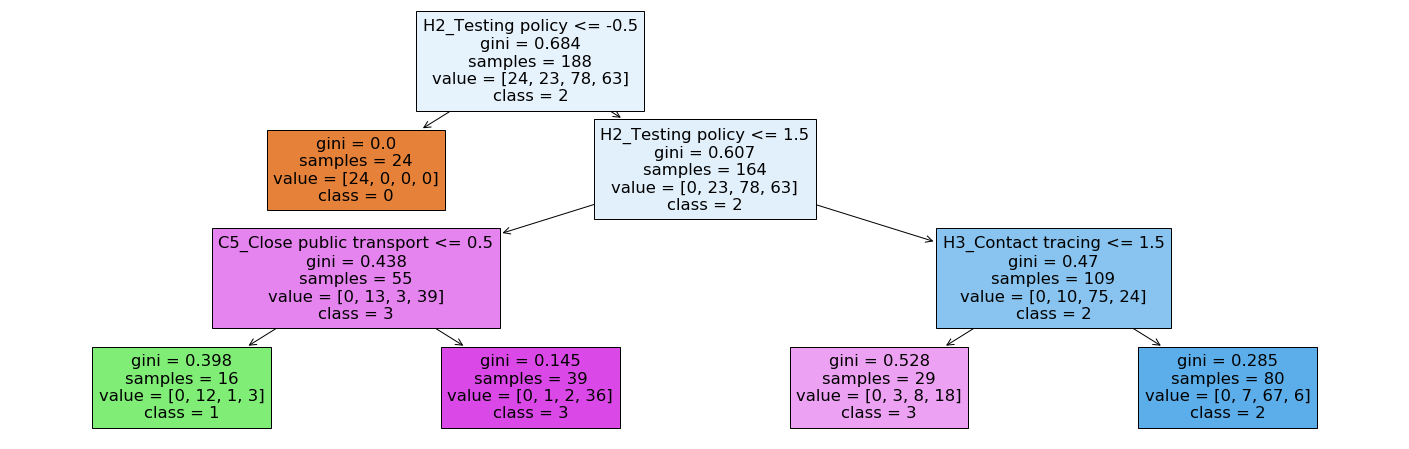

In [277]:
dtree = DecisionTreeClassifier(max_depth=3, min_impurity_decrease=0.02, random_state=42)
dtree.fit(pols_ds_cat[polc_columns_cat], pols_ds_cat['cluster_catpols'])#pols_ds_C['cluster'])

plt.figure(figsize=(25,8))
plot_tree(dtree, feature_names=polc_columns_cat, filled=True, class_names=[str(x) for x in range(4)]);

In [278]:
pols_ds_cat['cluster_dtree_cat'] = dtree.predict(pols_ds_cat[polc_columns_cat])

In [279]:
cluster_desc_cat = {0:'Unknown policies',
               1:'Lenient policies',
               2:'Active testing',
               3:'Middle testing'}

In [280]:
d = pols_ds_cat['cluster_dtree_cat'].to_dict()
cov_ds['Cluster_max_policy_cat'] = cov_ds['Country'].apply(lambda x: d[x])
cov_ds['Cluster_max_policy_cat_verb'] = cov_ds['Cluster_max_policy_cat'].apply(lambda x: cluster_desc_cat[x])

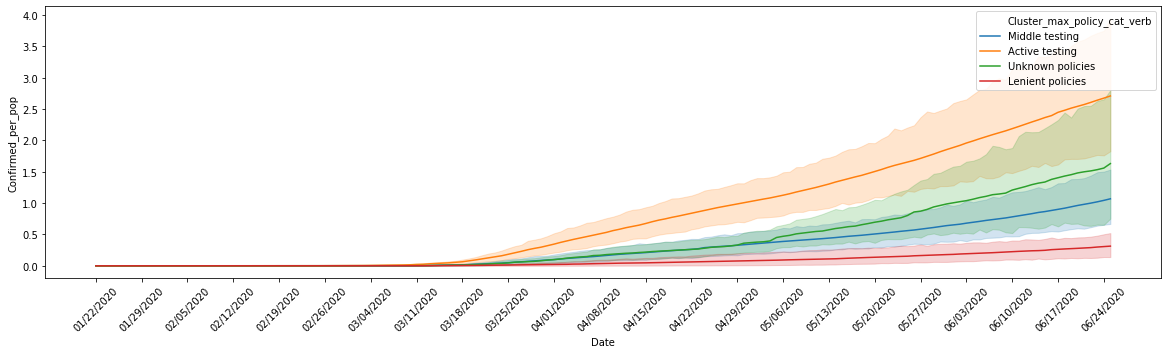

In [281]:
plt.figure(figsize=(20,5))
sns.lineplot(x='Date', y='Confirmed_per_pop', data=cov_ds, hue='Cluster_max_policy_cat_verb')
xticks = cov_ds['Date'].sort_values().drop_duplicates().values
plt.xticks(range(0, len(xticks), 7), xticks[::7], rotation=45)
#plt.xticks(xticks[0][::7], [x.get_text() for x in xticks[1]][::7], rotation=90)
plt.show()

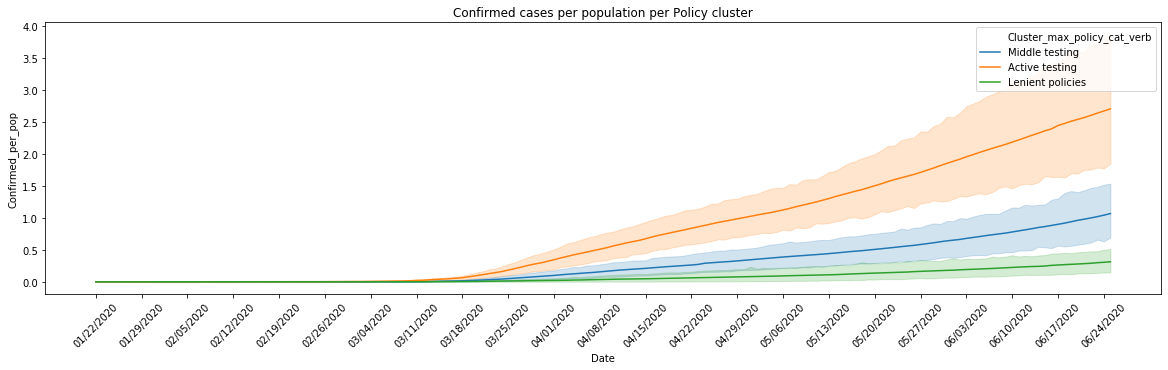

In [282]:
plt.figure(figsize=(20,5))
sns.lineplot(x='Date', y='Confirmed_per_pop', hue='Cluster_max_policy_cat_verb',
            data=cov_ds[~cov_ds['Cluster_max_policy_cat_verb'].isin(['Unknown policies'])])
xticks = cov_ds['Date'].sort_values().drop_duplicates().values
plt.xticks(range(0, len(xticks), 7), xticks[::7], rotation=45)
#plt.xticks(xticks[0][::7], [x.get_text() for x in xticks[1]][::7], rotation=90)
plt.title('Confirmed cases per population per Policy cluster')
plt.show()

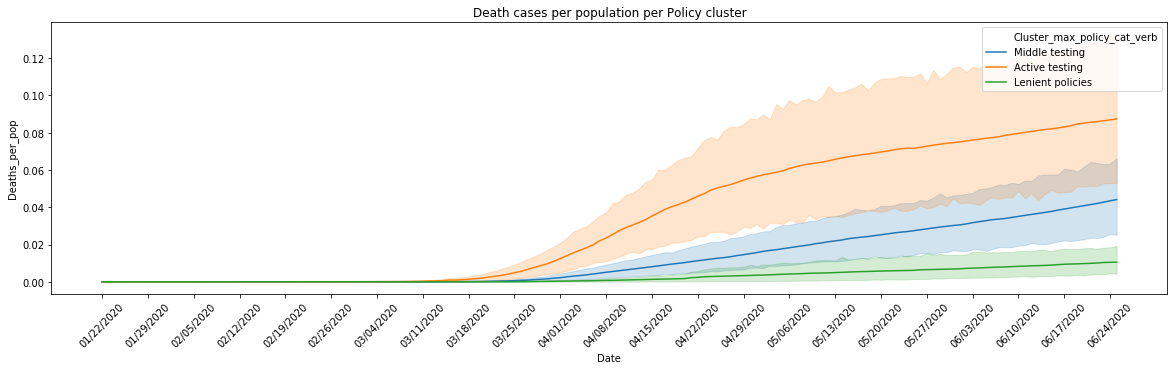

In [283]:
plt.figure(figsize=(20,5))
sns.lineplot(x='Date', y='Deaths_per_pop', hue='Cluster_max_policy_cat_verb',
            data=cov_ds[~cov_ds['Cluster_max_policy_cat_verb'].isin(['Unknown policies'])])
xticks = cov_ds['Date'].sort_values().drop_duplicates().values
plt.xticks(range(0, len(xticks), 7), xticks[::7], rotation=45)
#plt.xticks(xticks[0][::7], [x.get_text() for x in xticks[1]][::7], rotation=90)
plt.title('Death cases per population per Policy cluster')
plt.show()

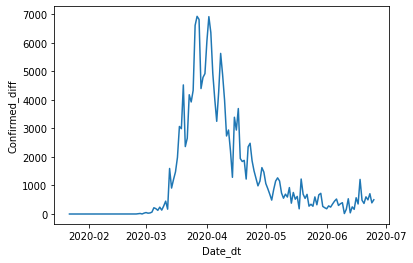

In [303]:
sns.lineplot(x='Date_dt',y='Confirmed_diff', data=cov_ds[cov_ds['Country']=='Germany'])